# Import basic libraries needed

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Import the data

In [29]:
start_date = '2000-01-01'
end_date = '2018-01-01'

In [30]:
'''
import pandas_datareader as pdr

df_to_save = pdr.DataReader(name='AAPL', data_source='yahoo', start=start_date, end=end_date)
df_to_save.head(5)

df_to_save.to_csv('AAPL_YAHOO 2.csv')

'''

df = pd.read_csv('AAPL_YAHOO1.csv', index_col='Date', parse_dates=True)

In [31]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,2.655498
2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,2.431611
2000-01-05,3.948661,3.678571,3.705357,3.714286,194580400.0,2.467196
2000-01-06,3.821429,3.392857,3.790179,3.392857,191993200.0,2.253689
2000-01-07,3.607143,3.410714,3.446429,3.553571,115183600.0,2.360442


In [32]:
df_close = df[['Close']].copy()
#df_close['Index'] = np.arange(len(df_close))
df_close.head()

,Close
Date,
2000-01-03,3.997768
2000-01-04,3.660714
2000-01-05,3.714286
2000-01-06,3.392857
2000-01-07,3.553571


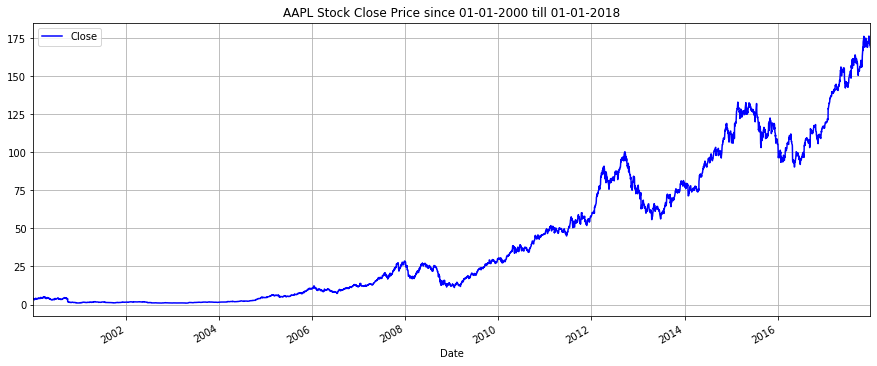

In [33]:
df_close.plot(figsize=(15, 6), 
                         color='blue', 
                         grid=True, 
                         title='AAPL Stock Close Price since 01-01-2000 till 01-01-2018')

# Train / Test split

In [34]:
len(df_close)

4528

In [35]:
# Train
train = df_close.iloc[:4400] # pandas.core.series.Series (4500,) **
train_index = train.index # pandas.core.indexes.datetimes.DatetimeIndex

# Test # 28 sessions
test = df_close.iloc[4400:] # pandas.core.series.Series (28,) **
test_index = test.index # pandas.core.indexes.datetimes.DatetimeIndex

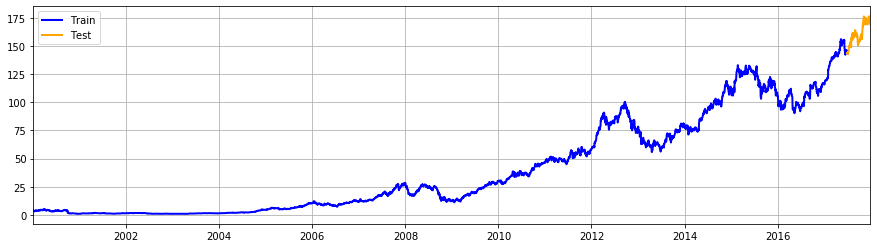

In [36]:
plt.figure(figsize=(15, 4))
plt.autoscale(tight=True, axis='x')
plt.grid(True)
plt.plot(train, lw=2, color='blue')
plt.plot(test, lw=2, color='orange')
plt.legend(['Train', 'Test'])

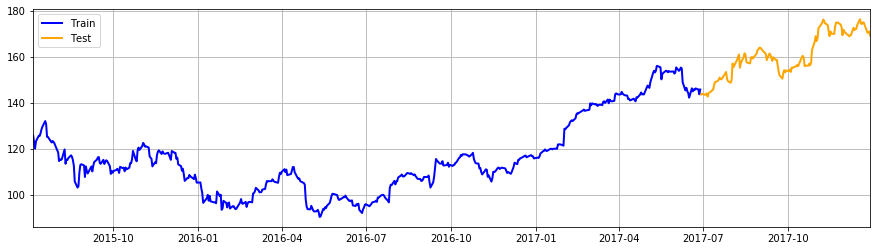

In [37]:
plt.figure(figsize=(15, 4))
plt.autoscale(tight=True, axis='x')
plt.grid(True)
plt.plot(train[-500:], lw=2, color='blue')
plt.plot(test, lw=2, color='orange')
plt.legend(['Train', 'Test'])

# Data preprocessing

### 1)  ```sklearn.preprocessing.MinMaxScaler()``` - data range made between 0 and 1

In [38]:
from sklearn.preprocessing import MinMaxScaler 

In [39]:
# From Pandas TimeSeries into NumPy array
# Train
train = train.values # numpy.ndarray (4400,)
train = train.reshape((len(train), 1)) # numpy.ndarray (4400, 1)

# Test
test = test.values # numpy.ndarray (128,)
test = test.reshape((len(test), 1)) # numpy.ndarray (128, 1)

In [40]:
# Fit the train data only sicne we don't want to give any additional info about values that model will predict
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [41]:
# Transform the data then export to Pandas TimeSeries as began
# Train
train_norm = scaler.transform(train) # numpy.ndarray (4400, 1)
train_norm = train_norm.tolist() # list of single value lists [[x], [y], [z]]
train_norm = np.squeeze(train_norm) # numpy.ndarray array([x, y, z])
train_norm = pd.Series(train_norm, train_index) # pandas.core.series.Series (4500,) **

# Test
test_norm = scaler.transform(test) # numpy.ndarray (128, 1)
test_norm = test_norm.tolist() # list of single value lists [[x], [y], [z]]
test_norm = np.squeeze(test_norm) # numpy.ndarray array([x, y, z])
test_norm = pd.Series(test_norm, test_index) # pandas.core.series.Series (28,) **

In [42]:
train_norm.head()

Date
2000-01-03    0.019725
2000-01-04    0.017553
2000-01-05    0.017898
2000-01-06    0.015827
2000-01-07    0.016862
dtype: float64

### 2) ```TimeseriesGenerator()``` - prepare train chunks for feeding model purposes.

In [43]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [44]:
n_input = 20

# All data and every single target are placed in the same set: train_norm
generator = TimeseriesGenerator(data=train_norm,
                                targets=train_norm,
                                length=n_input,
                                batch_size=1)

# SECOND

In [45]:
n_input2 = 40

# All data and every single target are placed in the same set: train_norm
generator2 = TimeseriesGenerator(data=train_norm,
                                targets=train_norm,
                                length=n_input2,
                                batch_size=1)

# Model building

## Model with generator 1
```n_input = 20```

In [46]:
from keras.models import Sequential
from keras.layers import Dense
from keras import layers

# Model fit

In [47]:
import time

## Model fit with generator

In [48]:
elapsed_all = []
for i in range(3):
    model = Sequential()

    # n_input = 20
    model.add(Dense(20, activation='relu', input_dim=n_input))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='sgd', loss='mse')

    
    
    start = time.time()

    model.fit_generator(generator=generator, 
                        epochs=500,
                        verbose=2)
                        #, steps_per_epoch=1) # by default when not specified = len(generator)
    end = time.time()
    elapsed = end - start
    elapsed_all.append(elapsed/60)
    
    # Model save
    model.save("my_MODEL1-relu-relu-linear-sgd_gen" + str(i) + ".h5")
    
    # Loss hist save
    pd.DataFrame(np.array(model.history.history['loss'])).to_csv("my_MODEL1-relu-relu-linear-sgd_gen_LOSS" + str(i) + ".csv")

Epoch 1/500
 - 6s - loss: 4.2385e-04
Epoch 2/500
 - 6s - loss: 2.9291e-04
Epoch 3/500
 - 5s - loss: 2.8604e-04
Epoch 4/500
 - 5s - loss: 2.7180e-04
Epoch 5/500
 - 6s - loss: 2.6298e-04
Epoch 6/500
 - 6s - loss: 2.5522e-04
Epoch 7/500
 - 6s - loss: 2.4744e-04
Epoch 8/500
 - 6s - loss: 2.3945e-04
Epoch 9/500
 - 6s - loss: 2.3142e-04
Epoch 10/500
 - 6s - loss: 2.3254e-04
Epoch 11/500
 - 6s - loss: 2.2191e-04
Epoch 12/500
 - 6s - loss: 2.1835e-04
Epoch 13/500
 - 6s - loss: 2.1136e-04
Epoch 14/500
 - 6s - loss: 2.0957e-04
Epoch 15/500
 - 6s - loss: 2.0331e-04
Epoch 16/500
 - 6s - loss: 1.9749e-04
Epoch 17/500
 - 6s - loss: 1.9811e-04
Epoch 18/500
 - 6s - loss: 1.9131e-04
Epoch 19/500
 - 6s - loss: 1.8711e-04
Epoch 20/500
 - 6s - loss: 1.8933e-04
Epoch 21/500
 - 6s - loss: 1.8017e-04
Epoch 22/500
 - 6s - loss: 1.7983e-04
Epoch 23/500
 - 6s - loss: 1.7822e-04
Epoch 24/500
 - 6s - loss: 1.7275e-04
Epoch 25/500
 - 6s - loss: 1.7268e-04
Epoch 26/500
 - 6s - loss: 1.7185e-04
Epoch 27/500
 - 6s - 

Epoch 214/500
 - 6s - loss: 6.0720e-05
Epoch 215/500
 - 6s - loss: 6.0767e-05
Epoch 216/500
 - 6s - loss: 6.0549e-05
Epoch 217/500
 - 6s - loss: 6.0730e-05
Epoch 218/500
 - 6s - loss: 6.0447e-05
Epoch 219/500
 - 6s - loss: 5.9935e-05
Epoch 220/500
 - 6s - loss: 6.0166e-05
Epoch 221/500
 - 6s - loss: 5.8665e-05
Epoch 222/500
 - 6s - loss: 6.0484e-05
Epoch 223/500
 - 6s - loss: 6.0262e-05
Epoch 224/500
 - 5s - loss: 5.8310e-05
Epoch 225/500
 - 6s - loss: 6.0182e-05
Epoch 226/500
 - 6s - loss: 5.8888e-05
Epoch 227/500
 - 6s - loss: 5.9671e-05
Epoch 228/500
 - 6s - loss: 5.8813e-05
Epoch 229/500
 - 6s - loss: 5.7618e-05
Epoch 230/500
 - 6s - loss: 5.8597e-05
Epoch 231/500
 - 5s - loss: 5.8311e-05
Epoch 232/500
 - 6s - loss: 5.8072e-05
Epoch 233/500
 - 5s - loss: 5.7469e-05
Epoch 234/500
 - 5s - loss: 5.7734e-05
Epoch 235/500
 - 6s - loss: 5.8837e-05
Epoch 236/500
 - 6s - loss: 5.9277e-05
Epoch 237/500
 - 6s - loss: 5.7258e-05
Epoch 238/500
 - 6s - loss: 5.7957e-05
Epoch 239/500
 - 6s - los

 - 6s - loss: 4.6313e-05
Epoch 425/500
 - 6s - loss: 4.6936e-05
Epoch 426/500
 - 5s - loss: 4.6829e-05
Epoch 427/500
 - 6s - loss: 4.5742e-05
Epoch 428/500
 - 6s - loss: 4.6614e-05
Epoch 429/500
 - 6s - loss: 4.6995e-05
Epoch 430/500
 - 6s - loss: 4.7433e-05
Epoch 431/500
 - 6s - loss: 4.5939e-05
Epoch 432/500
 - 6s - loss: 4.6255e-05
Epoch 433/500
 - 6s - loss: 4.5955e-05
Epoch 434/500
 - 6s - loss: 4.6406e-05
Epoch 435/500
 - 6s - loss: 4.5836e-05
Epoch 436/500
 - 6s - loss: 4.7125e-05
Epoch 437/500
 - 6s - loss: 4.6351e-05
Epoch 438/500
 - 6s - loss: 4.6287e-05
Epoch 439/500
 - 5s - loss: 4.5615e-05
Epoch 440/500
 - 5s - loss: 4.6505e-05
Epoch 441/500
 - 5s - loss: 4.5937e-05
Epoch 442/500
 - 6s - loss: 4.6342e-05
Epoch 443/500
 - 5s - loss: 4.6679e-05
Epoch 444/500
 - 6s - loss: 4.5428e-05
Epoch 445/500
 - 5s - loss: 4.6372e-05
Epoch 446/500
 - 6s - loss: 4.6068e-05
Epoch 447/500
 - 6s - loss: 4.5356e-05
Epoch 448/500
 - 6s - loss: 4.6433e-05
Epoch 449/500
 - 6s - loss: 4.4943e-05


 - 6s - loss: 5.3962e-05
Epoch 138/500
 - 5s - loss: 5.4930e-05
Epoch 139/500
 - 5s - loss: 5.3468e-05
Epoch 140/500
 - 6s - loss: 5.4057e-05
Epoch 141/500
 - 6s - loss: 5.3995e-05
Epoch 142/500
 - 6s - loss: 5.3466e-05
Epoch 143/500
 - 6s - loss: 5.4196e-05
Epoch 144/500
 - 6s - loss: 5.2944e-05
Epoch 145/500
 - 6s - loss: 5.4013e-05
Epoch 146/500
 - 6s - loss: 5.4595e-05
Epoch 147/500
 - 6s - loss: 5.3132e-05
Epoch 148/500
 - 6s - loss: 5.3798e-05
Epoch 149/500
 - 6s - loss: 5.3232e-05
Epoch 150/500
 - 6s - loss: 5.3433e-05
Epoch 151/500
 - 6s - loss: 5.3985e-05
Epoch 152/500
 - 6s - loss: 5.2840e-05
Epoch 153/500
 - 6s - loss: 5.2453e-05
Epoch 154/500
 - 6s - loss: 5.3513e-05
Epoch 155/500
 - 6s - loss: 5.2904e-05
Epoch 156/500
 - 5s - loss: 5.1525e-05
Epoch 157/500
 - 6s - loss: 5.2431e-05
Epoch 158/500
 - 6s - loss: 5.3765e-05
Epoch 159/500
 - 6s - loss: 5.2724e-05
Epoch 160/500
 - 6s - loss: 5.1986e-05
Epoch 161/500
 - 6s - loss: 5.2741e-05
Epoch 162/500
 - 6s - loss: 5.3316e-05


Epoch 348/500
 - 5s - loss: 4.5413e-05
Epoch 349/500
 - 6s - loss: 4.5702e-05
Epoch 350/500
 - 6s - loss: 4.4242e-05
Epoch 351/500
 - 6s - loss: 4.4438e-05
Epoch 352/500
 - 6s - loss: 4.4628e-05
Epoch 353/500
 - 6s - loss: 4.3665e-05
Epoch 354/500
 - 6s - loss: 4.4572e-05
Epoch 355/500
 - 6s - loss: 4.3712e-05
Epoch 356/500
 - 6s - loss: 4.4324e-05
Epoch 357/500
 - 6s - loss: 4.4024e-05
Epoch 358/500
 - 6s - loss: 4.4748e-05
Epoch 359/500
 - 6s - loss: 4.4844e-05
Epoch 360/500
 - 6s - loss: 4.4395e-05
Epoch 361/500
 - 6s - loss: 4.4077e-05
Epoch 362/500
 - 6s - loss: 4.4438e-05
Epoch 363/500
 - 6s - loss: 4.4644e-05
Epoch 364/500
 - 5s - loss: 4.4607e-05
Epoch 365/500
 - 6s - loss: 4.4827e-05
Epoch 366/500
 - 6s - loss: 4.3837e-05
Epoch 367/500
 - 6s - loss: 4.4696e-05
Epoch 368/500
 - 6s - loss: 4.4048e-05
Epoch 369/500
 - 6s - loss: 4.4298e-05
Epoch 370/500
 - 6s - loss: 4.4416e-05
Epoch 371/500
 - 6s - loss: 4.4417e-05
Epoch 372/500
 - 6s - loss: 4.4093e-05
Epoch 373/500
 - 6s - los

Epoch 60/500
 - 6s - loss: 6.3167e-05
Epoch 61/500
 - 6s - loss: 6.3115e-05
Epoch 62/500
 - 6s - loss: 6.1665e-05
Epoch 63/500
 - 6s - loss: 6.1434e-05
Epoch 64/500
 - 6s - loss: 6.0951e-05
Epoch 65/500
 - 6s - loss: 6.0000e-05
Epoch 66/500
 - 6s - loss: 6.0448e-05
Epoch 67/500
 - 6s - loss: 5.8786e-05
Epoch 68/500
 - 6s - loss: 5.8752e-05
Epoch 69/500
 - 6s - loss: 5.7911e-05
Epoch 70/500
 - 6s - loss: 5.7262e-05
Epoch 71/500
 - 6s - loss: 5.7397e-05
Epoch 72/500
 - 6s - loss: 5.7202e-05
Epoch 73/500
 - 6s - loss: 5.6520e-05
Epoch 74/500
 - 6s - loss: 5.7204e-05
Epoch 75/500
 - 6s - loss: 5.6225e-05
Epoch 76/500
 - 6s - loss: 5.4821e-05
Epoch 77/500
 - 6s - loss: 5.5624e-05
Epoch 78/500
 - 6s - loss: 5.4938e-05
Epoch 79/500
 - 6s - loss: 5.5529e-05
Epoch 80/500
 - 6s - loss: 5.4727e-05
Epoch 81/500
 - 6s - loss: 5.5155e-05
Epoch 82/500
 - 6s - loss: 5.4154e-05
Epoch 83/500
 - 6s - loss: 5.3798e-05
Epoch 84/500
 - 6s - loss: 5.3748e-05
Epoch 85/500
 - 6s - loss: 5.3163e-05
Epoch 86/500

 - 6s - loss: 4.5054e-05
Epoch 272/500
 - 6s - loss: 4.4666e-05
Epoch 273/500
 - 6s - loss: 4.4897e-05
Epoch 274/500
 - 6s - loss: 4.4176e-05
Epoch 275/500
 - 6s - loss: 4.4225e-05
Epoch 276/500
 - 6s - loss: 4.3828e-05
Epoch 277/500
 - 6s - loss: 4.4746e-05
Epoch 278/500
 - 6s - loss: 4.4349e-05
Epoch 279/500
 - 6s - loss: 4.5056e-05
Epoch 280/500
 - 6s - loss: 4.4336e-05
Epoch 281/500
 - 6s - loss: 4.5060e-05
Epoch 282/500
 - 6s - loss: 4.4868e-05
Epoch 283/500
 - 6s - loss: 4.4585e-05
Epoch 284/500
 - 6s - loss: 4.5083e-05
Epoch 285/500
 - 6s - loss: 4.3818e-05
Epoch 286/500
 - 6s - loss: 4.4373e-05
Epoch 287/500
 - 6s - loss: 4.4456e-05
Epoch 288/500
 - 6s - loss: 4.4416e-05
Epoch 289/500
 - 6s - loss: 4.4916e-05
Epoch 290/500
 - 6s - loss: 4.3947e-05
Epoch 291/500
 - 6s - loss: 4.4386e-05
Epoch 292/500
 - 6s - loss: 4.4287e-05
Epoch 293/500
 - 6s - loss: 4.4570e-05
Epoch 294/500
 - 6s - loss: 4.4423e-05
Epoch 295/500
 - 6s - loss: 4.3284e-05
Epoch 296/500
 - 6s - loss: 4.4841e-05


Epoch 482/500
 - 6s - loss: 4.1290e-05
Epoch 483/500
 - 6s - loss: 4.1517e-05
Epoch 484/500
 - 6s - loss: 4.1898e-05
Epoch 485/500
 - 6s - loss: 4.2065e-05
Epoch 486/500
 - 6s - loss: 4.2579e-05
Epoch 487/500
 - 6s - loss: 4.2485e-05
Epoch 488/500
 - 6s - loss: 4.2151e-05
Epoch 489/500
 - 6s - loss: 4.1893e-05
Epoch 490/500
 - 6s - loss: 4.2214e-05
Epoch 491/500
 - 6s - loss: 4.1954e-05
Epoch 492/500
 - 6s - loss: 4.2077e-05
Epoch 493/500
 - 6s - loss: 4.1566e-05
Epoch 494/500
 - 6s - loss: 4.1698e-05
Epoch 495/500
 - 6s - loss: 4.1639e-05
Epoch 496/500
 - 6s - loss: 4.1679e-05
Epoch 497/500
 - 6s - loss: 4.1329e-05
Epoch 498/500
 - 6s - loss: 4.1581e-05
Epoch 499/500
 - 6s - loss: 4.1254e-05
Epoch 500/500
 - 5s - loss: 4.1714e-05


In [49]:
elapsed_all
# [46.80198071400324, 46.70757741530736, 47.83365795612335]

[46.80198071400324, 46.70757741530736, 47.83365795612335]

## Model fit with generator2

In [50]:
elapsed2_all = []
for i in range(3):
    model2 = Sequential()

    # n_input = 20
    model2.add(Dense(20, activation='relu', input_dim=n_input2))
    model2.add(Dense(20, activation='relu'))
    model2.add(Dense(1, activation='linear'))

    model2.compile(optimizer='sgd', loss='mse')

    
    
    start2 = time.time()

    model2.fit_generator(generator=generator2, 
                        epochs=500,
                        verbose=2)
                        #, steps_per_epoch=1) # by default when not specified = len(generator)
    end2 = time.time()
    elapsed2 = end2 - start2
    elapsed2_all.append(elapsed2/60)
    
    # Model save
    model2.save("my_MODEL1-relu-relu-linear-sgd_gen2" + str(i) + ".h5")
    
    # Loss hist save
    pd.DataFrame(np.array(model2.history.history['loss'])).to_csv("my_MODEL1-relu-relu-linear-sgd_gen2_LOSS" + str(i) + ".csv")

Epoch 1/500
 - 6s - loss: 6.9476e-04
Epoch 2/500
 - 6s - loss: 3.0155e-04
Epoch 3/500
 - 6s - loss: 2.5914e-04
Epoch 4/500
 - 6s - loss: 2.3238e-04
Epoch 5/500
 - 6s - loss: 2.2051e-04
Epoch 6/500
 - 6s - loss: 2.1088e-04
Epoch 7/500
 - 6s - loss: 2.0061e-04
Epoch 8/500
 - 6s - loss: 2.0126e-04
Epoch 9/500
 - 6s - loss: 1.9138e-04
Epoch 10/500
 - 6s - loss: 1.8525e-04
Epoch 11/500
 - 6s - loss: 1.8300e-04
Epoch 12/500
 - 6s - loss: 1.7973e-04
Epoch 13/500
 - 6s - loss: 1.7747e-04
Epoch 14/500
 - 6s - loss: 1.7346e-04
Epoch 15/500
 - 6s - loss: 1.7163e-04
Epoch 16/500
 - 6s - loss: 1.6746e-04
Epoch 17/500
 - 6s - loss: 1.6976e-04
Epoch 18/500
 - 6s - loss: 1.6481e-04
Epoch 19/500
 - 6s - loss: 1.5972e-04
Epoch 20/500
 - 6s - loss: 1.5544e-04
Epoch 21/500
 - 6s - loss: 1.5416e-04
Epoch 22/500
 - 6s - loss: 1.5355e-04
Epoch 23/500
 - 6s - loss: 1.4960e-04
Epoch 24/500
 - 6s - loss: 1.4692e-04
Epoch 25/500
 - 6s - loss: 1.4433e-04
Epoch 26/500
 - 6s - loss: 1.4367e-04
Epoch 27/500
 - 6s - 

Epoch 214/500
 - 6s - loss: 5.7832e-05
Epoch 215/500
 - 6s - loss: 5.6504e-05
Epoch 216/500
 - 6s - loss: 5.7153e-05
Epoch 217/500
 - 6s - loss: 5.6057e-05
Epoch 218/500
 - 6s - loss: 5.5333e-05
Epoch 219/500
 - 6s - loss: 5.7394e-05
Epoch 220/500
 - 6s - loss: 5.6558e-05
Epoch 221/500
 - 6s - loss: 5.5835e-05
Epoch 222/500
 - 7s - loss: 5.7443e-05
Epoch 223/500
 - 6s - loss: 5.5340e-05
Epoch 224/500
 - 6s - loss: 5.5834e-05
Epoch 225/500
 - 6s - loss: 5.5685e-05
Epoch 226/500
 - 6s - loss: 5.6483e-05
Epoch 227/500
 - 6s - loss: 5.4796e-05
Epoch 228/500
 - 6s - loss: 5.4904e-05
Epoch 229/500
 - 6s - loss: 5.7078e-05
Epoch 230/500
 - 6s - loss: 5.5600e-05
Epoch 231/500
 - 6s - loss: 5.6184e-05
Epoch 232/500
 - 6s - loss: 5.5820e-05
Epoch 233/500
 - 6s - loss: 5.5474e-05
Epoch 234/500
 - 6s - loss: 5.6726e-05
Epoch 235/500
 - 6s - loss: 5.5662e-05
Epoch 236/500
 - 6s - loss: 5.4937e-05
Epoch 237/500
 - 6s - loss: 5.5712e-05
Epoch 238/500
 - 6s - loss: 5.4901e-05
Epoch 239/500
 - 6s - los

 - 6s - loss: 4.8898e-05
Epoch 425/500
 - 6s - loss: 4.7744e-05
Epoch 426/500
 - 6s - loss: 4.8949e-05
Epoch 427/500
 - 6s - loss: 4.8932e-05
Epoch 428/500
 - 5s - loss: 4.8090e-05
Epoch 429/500
 - 6s - loss: 4.8346e-05
Epoch 430/500
 - 6s - loss: 4.8391e-05
Epoch 431/500
 - 6s - loss: 4.8862e-05
Epoch 432/500
 - 6s - loss: 4.8469e-05
Epoch 433/500
 - 6s - loss: 4.8018e-05
Epoch 434/500
 - 6s - loss: 4.8466e-05
Epoch 435/500
 - 6s - loss: 4.8403e-05
Epoch 436/500
 - 6s - loss: 4.7356e-05
Epoch 437/500
 - 6s - loss: 4.8042e-05
Epoch 438/500
 - 6s - loss: 4.8291e-05
Epoch 439/500
 - 6s - loss: 4.8835e-05
Epoch 440/500
 - 6s - loss: 4.8461e-05
Epoch 441/500
 - 6s - loss: 4.8295e-05
Epoch 442/500
 - 6s - loss: 4.8634e-05
Epoch 443/500
 - 6s - loss: 4.7751e-05
Epoch 444/500
 - 6s - loss: 4.7645e-05
Epoch 445/500
 - 6s - loss: 4.7665e-05
Epoch 446/500
 - 6s - loss: 4.6966e-05
Epoch 447/500
 - 6s - loss: 4.8255e-05
Epoch 448/500
 - 6s - loss: 4.8372e-05
Epoch 449/500
 - 6s - loss: 4.7817e-05


 - 6s - loss: 5.4907e-05
Epoch 138/500
 - 6s - loss: 5.5340e-05
Epoch 139/500
 - 6s - loss: 5.4479e-05
Epoch 140/500
 - 6s - loss: 5.5664e-05
Epoch 141/500
 - 6s - loss: 5.5751e-05
Epoch 142/500
 - 6s - loss: 5.6861e-05
Epoch 143/500
 - 6s - loss: 5.6355e-05
Epoch 144/500
 - 6s - loss: 5.5196e-05
Epoch 145/500
 - 6s - loss: 5.4689e-05
Epoch 146/500
 - 6s - loss: 5.5167e-05
Epoch 147/500
 - 6s - loss: 5.4290e-05
Epoch 148/500
 - 6s - loss: 5.3793e-05
Epoch 149/500
 - 6s - loss: 5.4073e-05
Epoch 150/500
 - 6s - loss: 5.4236e-05
Epoch 151/500
 - 6s - loss: 5.4655e-05
Epoch 152/500
 - 6s - loss: 5.4713e-05
Epoch 153/500
 - 6s - loss: 5.4178e-05
Epoch 154/500
 - 6s - loss: 5.3135e-05
Epoch 155/500
 - 6s - loss: 5.3759e-05
Epoch 156/500
 - 6s - loss: 5.4904e-05
Epoch 157/500
 - 6s - loss: 5.3996e-05
Epoch 158/500
 - 6s - loss: 5.4065e-05
Epoch 159/500
 - 6s - loss: 5.4058e-05
Epoch 160/500
 - 6s - loss: 5.4204e-05
Epoch 161/500
 - 6s - loss: 5.3192e-05
Epoch 162/500
 - 6s - loss: 5.3366e-05


Epoch 348/500
 - 7s - loss: 4.6867e-05
Epoch 349/500
 - 6s - loss: 4.6419e-05
Epoch 350/500
 - 6s - loss: 4.6502e-05
Epoch 351/500
 - 6s - loss: 4.6609e-05
Epoch 352/500
 - 6s - loss: 4.6744e-05
Epoch 353/500
 - 6s - loss: 4.6928e-05
Epoch 354/500
 - 6s - loss: 4.6865e-05
Epoch 355/500
 - 6s - loss: 4.7165e-05
Epoch 356/500
 - 6s - loss: 4.7363e-05
Epoch 357/500
 - 6s - loss: 4.6708e-05
Epoch 358/500
 - 6s - loss: 4.6131e-05
Epoch 359/500
 - 6s - loss: 4.5972e-05
Epoch 360/500
 - 6s - loss: 4.6153e-05
Epoch 361/500
 - 6s - loss: 4.7370e-05
Epoch 362/500
 - 6s - loss: 4.6561e-05
Epoch 363/500
 - 6s - loss: 4.6742e-05
Epoch 364/500
 - 6s - loss: 4.6761e-05
Epoch 365/500
 - 6s - loss: 4.6906e-05
Epoch 366/500
 - 6s - loss: 4.7067e-05
Epoch 367/500
 - 6s - loss: 4.6680e-05
Epoch 368/500
 - 6s - loss: 4.6718e-05
Epoch 369/500
 - 6s - loss: 4.6417e-05
Epoch 370/500
 - 6s - loss: 4.7090e-05
Epoch 371/500
 - 6s - loss: 4.6990e-05
Epoch 372/500
 - 6s - loss: 4.6111e-05
Epoch 373/500
 - 6s - los

Epoch 60/500
 - 6s - loss: 8.0880e-05
Epoch 61/500
 - 6s - loss: 8.0733e-05
Epoch 62/500
 - 6s - loss: 8.0288e-05
Epoch 63/500
 - 6s - loss: 7.9590e-05
Epoch 64/500
 - 6s - loss: 8.0211e-05
Epoch 65/500
 - 6s - loss: 7.9819e-05
Epoch 66/500
 - 6s - loss: 7.8903e-05
Epoch 67/500
 - 6s - loss: 7.7539e-05
Epoch 68/500
 - 6s - loss: 7.7271e-05
Epoch 69/500
 - 6s - loss: 7.8215e-05
Epoch 70/500
 - 6s - loss: 7.6110e-05
Epoch 71/500
 - 6s - loss: 7.7625e-05
Epoch 72/500
 - 6s - loss: 7.7267e-05
Epoch 73/500
 - 6s - loss: 7.5249e-05
Epoch 74/500
 - 6s - loss: 7.4656e-05
Epoch 75/500
 - 6s - loss: 7.3670e-05
Epoch 76/500
 - 6s - loss: 7.4684e-05
Epoch 77/500
 - 6s - loss: 7.6889e-05
Epoch 78/500
 - 6s - loss: 7.4262e-05
Epoch 79/500
 - 6s - loss: 7.5304e-05
Epoch 80/500
 - 6s - loss: 7.4096e-05
Epoch 81/500
 - 6s - loss: 7.4273e-05
Epoch 82/500
 - 6s - loss: 7.3928e-05
Epoch 83/500
 - 6s - loss: 7.1838e-05
Epoch 84/500
 - 6s - loss: 7.1577e-05
Epoch 85/500
 - 6s - loss: 7.3865e-05
Epoch 86/500

 - 4s - loss: 5.0719e-05
Epoch 272/500
 - 4s - loss: 5.3795e-05
Epoch 273/500
 - 4s - loss: 5.2662e-05
Epoch 274/500
 - 4s - loss: 5.1981e-05
Epoch 275/500
 - 4s - loss: 5.2347e-05
Epoch 276/500
 - 4s - loss: 5.2781e-05
Epoch 277/500
 - 4s - loss: 5.1686e-05
Epoch 278/500
 - 4s - loss: 5.2106e-05
Epoch 279/500
 - 4s - loss: 5.0971e-05
Epoch 280/500
 - 4s - loss: 5.2068e-05
Epoch 281/500
 - 4s - loss: 5.2607e-05
Epoch 282/500
 - 4s - loss: 5.2804e-05
Epoch 283/500
 - 4s - loss: 5.2305e-05
Epoch 284/500
 - 4s - loss: 5.1248e-05
Epoch 285/500
 - 4s - loss: 5.1953e-05
Epoch 286/500
 - 4s - loss: 5.1387e-05
Epoch 287/500
 - 4s - loss: 5.2864e-05
Epoch 288/500
 - 4s - loss: 5.2000e-05
Epoch 289/500
 - 4s - loss: 5.0658e-05
Epoch 290/500
 - 4s - loss: 5.2056e-05
Epoch 291/500
 - 4s - loss: 5.1734e-05
Epoch 292/500
 - 4s - loss: 5.1213e-05
Epoch 293/500
 - 4s - loss: 5.2035e-05
Epoch 294/500
 - 4s - loss: 5.0617e-05
Epoch 295/500
 - 4s - loss: 5.2322e-05
Epoch 296/500
 - 4s - loss: 5.1992e-05


Epoch 482/500
 - 4s - loss: 4.6931e-05
Epoch 483/500
 - 4s - loss: 4.6698e-05
Epoch 484/500
 - 4s - loss: 4.7077e-05
Epoch 485/500
 - 4s - loss: 4.6449e-05
Epoch 486/500
 - 4s - loss: 4.6015e-05
Epoch 487/500
 - 4s - loss: 4.5806e-05
Epoch 488/500
 - 4s - loss: 4.6215e-05
Epoch 489/500
 - 4s - loss: 4.5927e-05
Epoch 490/500
 - 4s - loss: 4.6408e-05
Epoch 491/500
 - 4s - loss: 4.6070e-05
Epoch 492/500
 - 4s - loss: 4.6326e-05
Epoch 493/500
 - 4s - loss: 4.6600e-05
Epoch 494/500
 - 4s - loss: 4.6118e-05
Epoch 495/500
 - 4s - loss: 4.6722e-05
Epoch 496/500
 - 4s - loss: 4.5694e-05
Epoch 497/500
 - 4s - loss: 4.7247e-05
Epoch 498/500
 - 4s - loss: 4.6799e-05
Epoch 499/500
 - 4s - loss: 4.6421e-05
Epoch 500/500
 - 4s - loss: 4.6116e-05


In [51]:
elapsed2_all
[47.68329141139984, 48.15160831610362, 42.368217051029205]

[47.68329141139984, 48.15160831610362, 42.368217051029205]

___

___

In [ ]:
'''# Model has been trained and saved already. Now just import model from the file

from keras.models import load_model

model = load_model('my_model_1.h5')
model.summary()'''

___

### 1 Day Ahead Prediction

In [ ]:
# Prediction
y_hat = model.predict(train_norm[-n_input:].values.reshape((1, n_input))).squeeze()
y_hat

In [ ]:
# Actual value
y = test_norm[0]
y

In [ ]:
# Error = y_hat - y
e = y_hat - y
e

### Error evaluation metrics:

In [ ]:
# MSE
# MAE
# MPE

___

### Loss function visualization

In [ ]:
'''model.history.history.keys()'''

In [ ]:
'''plt.figure(figsize=(15, 5))
plt.grid(True)
plt.plot(model.history.history['loss'])'''

___

## Prediction set for next 20 days

In [52]:
predictions = []

# Initialize prediction process using very last 20 values within train set, 
# in order to predict first 'future' value.
# Tricky thing is that we actualyy know that future value, 
# since we approximate not further than length of the test set.

first_batch = train_norm[-n_input:].values.reshape((1, n_input)) # numpy.ndarray (1, 20)

# Predict 20 sessions ahead
# Note that later prediction will base on previous predictions what makes further outputs more noisy 
for i in range(20):
    y_hat = model.predict(first_batch).squeeze() # numpy.ndarray ()
    predictions.append(y_hat.tolist())
    
    next_batch = np.append(first_batch, y_hat)[1:].reshape((1, n_input)) # numpy.ndarray (1, 20)
    first_batch = next_batch

In [53]:
# Do the inversion of normalized values
true_predictions = scaler.inverse_transform([predictions])[0]

# True predictions series object
df_true_predictions = pd.Series(true_predictions, test_index[:20])

___

### ANN Predictions against the Real Values 

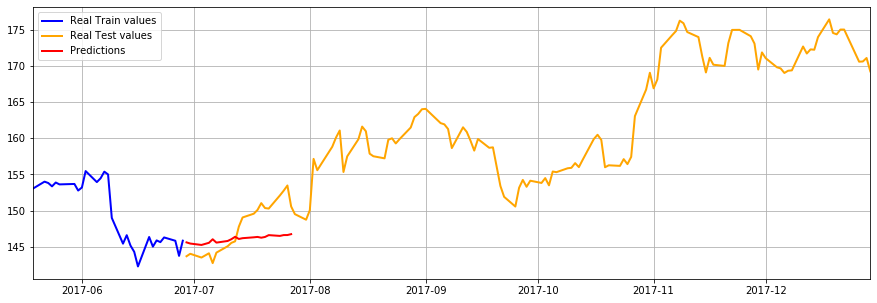

In [54]:
plt.figure(figsize=(15, 5))
plt.autoscale(tight=True, axis='x')
plt.grid(True)
plt.plot(train_index[-28:], train[-28:], lw=2, color='blue')
plt.plot(test_index, test, lw=2, color='orange')

plt.plot(test_index[:20], true_predictions, lw=2, color='red')

days = []
for i in range(1, 21):
    days.append('day'+str(i))
    
plt.xticks()

plt.legend(['Real Train values', 'Real Test values', 'Predictions'])

## Prediction set for next 20 days 2

In [55]:
predictions2 = []

# Initialize prediction process using very last 40 values within train set, 
# in order to predict first 'future' value.
# Tricky thing is that we actualyy know that future value, 
# since we approximate not further than length of the test set.

first_batch2 = train_norm[-n_input2:].values.reshape((1, n_input2)) # numpy.ndarray (1, 40)

# Predict 20 sessions ahead
# Note that later prediction will base on previous predictions what makes further outputs more noisy 
for i in range(20):
    y_hat2 = model2.predict(first_batch2).squeeze() # numpy.ndarray ()
    predictions2.append(y_hat2.tolist())
    
    next_batch2 = np.append(first_batch2, y_hat2)[1:].reshape((1, n_input2)) # numpy.ndarray (1, 40)
    first_batch2 = next_batch2

In [56]:
# Do the inversion of normalized values
true_predictions2 = scaler.inverse_transform([predictions2])[0]

# True predictions series object
df_true_predictions2 = pd.Series(true_predictions2, test_index[:20])

___

### ANN Predictions against the Real Values 

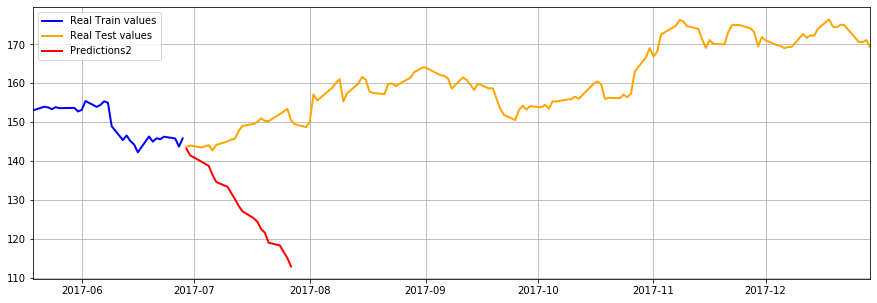

In [57]:
plt.figure(figsize=(15, 5))
plt.autoscale(tight=True, axis='x')
plt.grid(True)
plt.plot(train_index[-28:], train[-28:], lw=2, color='blue')
plt.plot(test_index, test, lw=2, color='orange')

plt.plot(test_index[:20], true_predictions2, lw=2, color='red')

days = []
for i in range(1, 21):
    days.append('day'+str(i))
    
plt.xticks()

plt.legend(['Real Train values', 'Real Test values', 'Predictions2'])

___

### Rolling mean against real data and predictions from ANN

In [ ]:
# Prediction of 20 sessions ahead
# It is rolling average with 20 days span
# Further predictions base on previous

predictions_20_avg = []

batch = train[-20:].squeeze()
for i in range(20):
    prediction = batch.mean()
    predictions_20_avg.append(prediction)
    
    
    next_batch = np.append(batch[1:], prediction)
    batch = next_batch

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(np.arange(-9, 1),
         train[-10:],
         color='blue')

plt.plot(np.arange(1, len(test)+1),
         test,
         color='orange')

plt.plot(np.arange(1, len(true_predictions)+1),
         true_predictions,
         color='red')

plt.plot(np.arange(1, len(predictions_20_avg)+1),
         predictions_20_avg,
         color='grey')

plt.legend(['Real Train Data', 'Real Test Data', 'ANN Predictions', '20 Days AVG Predictions'])

____

In [ ]:
# Upper and lower bounds of avg +- std (20-days-span)

mean_20 = df[['Close']].rolling(window=20).mean()
std_20 = df[['Close']].rolling(window=20).std()

# Lower
std_minus = mean_20 - std_20
std_minus.dropna(inplace=True)

# Upper
std_plus = mean_20 + std_20
std_plus.dropna(inplace=True)

In [ ]:
# Plot 20 days avg window including sts, against real and predicted data
plt.figure(figsize=(15, 5))
plt.plot(df_close, lw=3, color='blue')
plt.plot(mean_20, lw=2, color='orange')

plt.fill_between(std_plus.index, std_minus.Close, std_plus.Close, alpha=0.3, color='orange')

plt.plot(df_true_predictions, lw=2, color='red', ls='--')


plt.autoscale(tight=True, axis='y')

plt.legend(['Close price', '20 days rolling avg. +/- 20 day rolling std.', 'Predictions'])

plt.xlim('2017-01-01', '2017-12-29')
plt.ylim(100, 180)